In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

In [3]:
dataset = pd.read_csv("creditcard.csv", engine='python')
#dataset.head
print(list(dataset.columns))
dataset.describe()
dataset[Time]

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


NameError: name 'Time' is not defined

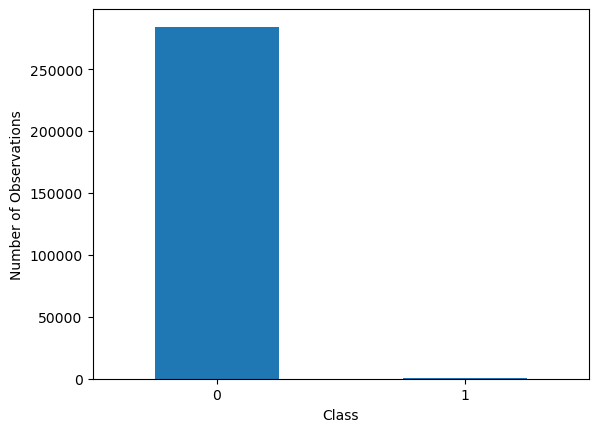

In [4]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [5]:
sc=StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [6]:
'''The last column in the dataset is our target variable.'''

raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=4
)
train_labels.shape

(227845,)

In [7]:
'''Use only normal transactions to train the Autoencoder.

Normal data has a value of 0 in the target variable. Using the target variable to create a normal and fraud dataset.'''

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#creating normal and fraud datasets

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]

fraud_test_data.shape

(101, 30)

In [8]:
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                
                        activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dense_4 (Dense)             (None, 14)                112       
                                                                 
 dense_5 (Dense)             (None, 30)                450   

In [9]:
#Compile the Autoencoder

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [10]:
#Train the Autoencoder

history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=10,
            
                    validation_data=(test_data, test_data),
            
                    ).history

Epoch 1/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7620 - accuracy: 0.4085 - val_loss: 0.8151 - val_accuracy: 0.4455
Epoch 2/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.6888 - accuracy: 0.4401 - val_loss: 0.7930 - val_accuracy: 0.4352
Epoch 3/10
7108/7108 [==============================] - 7s 1ms/step - loss: 0.6758 - accuracy: 0.4260 - val_loss: 0.7832 - val_accuracy: 0.4164
Epoch 4/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.6682 - accuracy: 0.4155 - val_loss: 0.7764 - val_accuracy: 0.4066
Epoch 5/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.6610 - accuracy: 0.4040 - val_loss: 0.7679 - val_accuracy: 0.3882
Epoch 6/10
7108/7108 [==============================] - 9s 1ms/step - loss: 0.6507 - accuracy: 0.3799 - val_loss: 0.7609 - val_accuracy: 0.3598
Epoch 7/10
7108/7108 [==============================] - 8s 1ms/step - loss: 0.6442 - accuracy: 0.3753 - val_loss: 0.7534 - val_accuracy:

In [11]:
predict = autoencoder.predict(test_data)

1781/1781 [==============================] - 1s 715us/step


In [12]:
mse = np.mean(np.power(predict-test_data,2),axis=1)
error_df = pd.DataFrame({"Reconstruction_Error":mse,"True_Class":test_labels})
error_df

,Reconstruction_Error,True_Class
0,0.105863,False
1,0.134988,False
2,0.119411,False
3,0.245140,False
4,0.143218,False
...,...,...
56957,1.497451,False
56958,0.467250,False
56959,0.279354,False
56960,0.117736,False


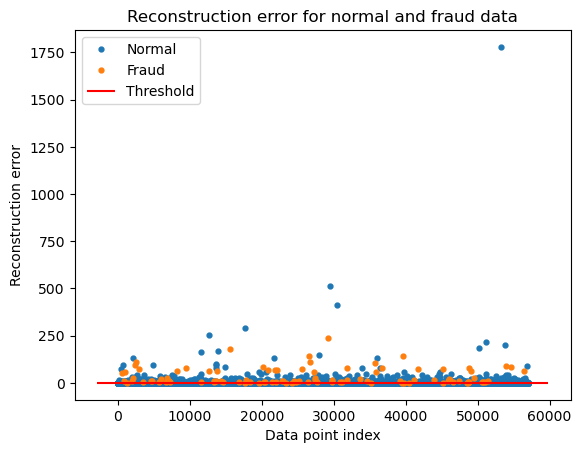

In [13]:
threshold_fixed = 0.50
groups = error_df.groupby('True_Class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_Error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [14]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_Error.values]
error_df['pred'] =pred_y
error_df

,Reconstruction_Error,True_Class,pred
0,0.105863,False,0
1,0.134988,False,0
2,0.119411,False,0
3,0.245140,False,0
4,0.143218,False,0
...,...,...,...
56957,1.497451,False,1
56958,0.467250,False,0
56959,0.279354,False,0
56960,0.117736,False,0


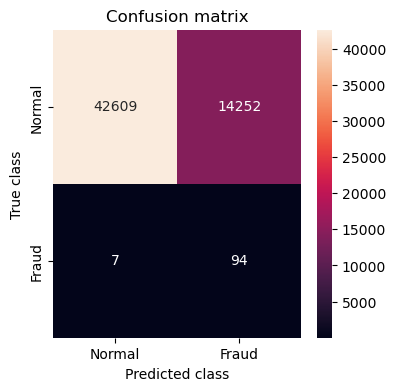

In [15]:
Labels=["Normal","Fraud"]
conf_matrix = confusion_matrix(error_df.True_Class, error_df.pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

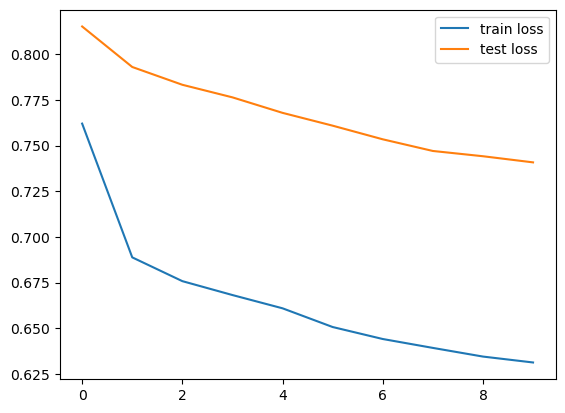

In [16]:
plt.plot(history['loss'],label="train loss")
plt.plot(history['val_loss'],label="test loss")
plt.legend(loc="upper right")
plt.show()